In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import  r2_score,mean_absolute_error,mean_squared_log_error,median_absolute_error,explained_variance_score
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("../data/StockX-Data-Consolidated.csv")

In [3]:
# Train-Test Splitting
data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
x = data.drop(["Pct_change",'Sale_Price','Unnamed:_0'], axis=1)
y = data["Pct_change"]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3)

## Xgboost before cross-validation: finding benchmark

In [4]:
data_dmatrix = xgb.DMatrix(data=x,label=y)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [5]:
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [6]:
params['eval_metric'] = "rmse"
num_boost_round = 900

In [7]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

In [8]:
cv_results['test-rmse-mean'].min()

0.23306240000000003

In [9]:
len(x_train.columns)

30

##### Number of attributes/columns in X: 30
##### *Training set cv_result rmse: 0.2331*

## Cross-validation and Hyperparamter tuning
### 1. Grid search for max_depth and min_child_weight

In [12]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(2,5)
    for min_child_weight in range(5,10)
]

In [13]:
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)

CV with max_depth=2, min_child_weight=5


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	RMSE 0.2881532 for 899 rounds
CV with max_depth=2, min_child_weight=6
	RMSE 0.28955659999999994 for 899 rounds
CV with max_depth=2, min_child_weight=7
	RMSE 0.288966 for 899 rounds
CV with max_depth=2, min_child_weight=8
	RMSE 0.2895354 for 898 rounds
CV with max_depth=2, min_child_weight=9
	RMSE 0.29252880000000003 for 899 rounds
CV with max_depth=3, min_child_weight=5
	RMSE 0.23306240000000003 for 897 rounds
CV with max_depth=3, min_child_weight=6
	RMSE 0.2368984 for 746 rounds
CV with max_depth=3, min_child_weight=7
	RMSE 0.2350916 for 868 rounds
CV with max_depth=3, min_child_weight=8
	RMSE 0.23571459999999997 for 899 rounds
CV with max_depth=3, min_child_weight=9
	RMSE 0.2363892 for 899 rounds
CV with max_depth=4, min_child_weight=5
	RMSE 0.2183342 for 650 rounds
CV with max_depth=4, min_child_weight=6
	RMSE 0.2192956 for 654 rounds
CV with max_depth=4, min_child_weight=7
	RMSE 0.21860980000000002 for 713 rounds
CV with max_depth=4, min_child_weight=8
	RMSE 0.2190796 for 826 roun

In [14]:
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

Best params: 4, 5, RMSE: 0.2183342


#### *Update max_depth and min_child_weight hyperparameter*

In [15]:
params['max_depth'] = 4
params['min_child_weight'] = 5

### 2. Grid Search for subsample and colsample_bytree (shrinkage parameters)

In [16]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [17]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed = 42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	RMSE 0.2183342 for 650 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 0.221191 for 597 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 0.2179024 for 680 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 0.22082980000000002 for 731 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 0.22277180000000002 for 586 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 0.2257518 for 491 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 0.2253476 for 595 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 0.22928779999999999 for 530 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 0.22690520000000003 for 603 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 0.2272164 for 622 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 0.2319948 for 447 rounds
CV with subsample=0.8, colsample=0.7
	RMSE 0.2324894 for 513 rounds
CV with subsample=0.7, colsample=1.0
	RMSE 0.23188979999999998 for 453 rounds
CV with subsample=0.7, colsample=0.9
	RMSE 0.23214700000000002 for 476 rounds
CV with subsample=0.7, col

In [19]:
params['subsample'] = 1.0
params['colsample_bytree'] = 0.8

### 3. Grid Search for ETA

In [20]:
%time

min_rmse = float("Inf")
best_params = None
for eta in [.5, .45, .4, .35, .3, .2, .1, .05]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['rmse'],
        early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_rmse))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 34.1 µs
CV with eta=0.5


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	MAE 0.2249366 for 360 rounds

CV with eta=0.45
	MAE 0.222492 for 499 rounds

CV with eta=0.4
	MAE 0.22184959999999995 for 460 rounds

CV with eta=0.35
	MAE 0.21907080000000004 for 772 rounds

CV with eta=0.3
	MAE 0.2179024 for 680 rounds

CV with eta=0.2
	MAE 0.2197826 for 899 rounds

CV with eta=0.1
	MAE 0.23490039999999998 for 899 rounds

CV with eta=0.05
	MAE 0.2580154 for 899 rounds

Best params: 0.3, MAE: 0.2179024


In [21]:
params['eta'] = .3

## Results

#### - *Xgb parameters in hyperparameter tuning using cross validation*

In [34]:
params = {'colsample_bytree': 0.8,
 'eta': 0.3,
 'eval_metric': 'rmse',
 'max_depth': 4,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 1.0}

#### - *Model Prediction using above parameters*

In [36]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=900,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:1.27434
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:1.00803
[2]	Test-rmse:0.817257
[3]	Test-rmse:0.69597
[4]	Test-rmse:0.607115
[5]	Test-rmse:0.554422
[6]	Test-rmse:0.521313
[7]	Test-rmse:0.479196
[8]	Test-rmse:0.45451
[9]	Test-rmse:0.437458
[10]	Test-rmse:0.41687
[11]	Test-rmse:0.410119
[12]	Test-rmse:0.400894
[13]	Test-rmse:0.398131
[14]	Test-rmse:0.393212
[15]	Test-rmse:0.377028
[16]	Test-rmse:0.366455
[17]	Test-rmse:0.3645
[18]	Test-rmse:0.36167
[19]	Test-rmse:0.354895
[20]	Test-rmse:0.353198
[21]	Test-rmse:0.351144
[22]	Test-rmse:0.344157
[23]	Test-rmse:0.33821
[24]	Test-rmse:0.336839
[25]	Test-rmse:0.336218
[26]	Test-rmse:0.330613
[27]	Test-rmse:0.328902
[28]	Test-rmse:0.326549
[29]	Test-rmse:0.325442
[30]	Test-rmse:0.323724
[31]	Test-rmse:0.323153
[32]	Test-rmse:0.317711
[33]	Test-rmse:0.31551
[34]	Test-rmse:0.310925
[35]	Test-rmse:0.310323
[36]	Test-rmse:0.308019
[37]	Test-rmse:0.307524
[38]	Test-rmse:0.305509
[39]	Test-rmse:0.303288
[40

[331]	Test-rmse:0.216503
[332]	Test-rmse:0.216477
[333]	Test-rmse:0.216046
[334]	Test-rmse:0.216018
[335]	Test-rmse:0.216022
[336]	Test-rmse:0.216066
[337]	Test-rmse:0.216055
[338]	Test-rmse:0.216032
[339]	Test-rmse:0.216008
[340]	Test-rmse:0.215975
[341]	Test-rmse:0.215961
[342]	Test-rmse:0.215976
[343]	Test-rmse:0.215978
[344]	Test-rmse:0.215837
[345]	Test-rmse:0.215852
[346]	Test-rmse:0.215643
[347]	Test-rmse:0.215576
[348]	Test-rmse:0.215327
[349]	Test-rmse:0.215294
[350]	Test-rmse:0.215265
[351]	Test-rmse:0.215209
[352]	Test-rmse:0.21522
[353]	Test-rmse:0.215234
[354]	Test-rmse:0.215252
[355]	Test-rmse:0.215234
[356]	Test-rmse:0.215239
[357]	Test-rmse:0.214993
[358]	Test-rmse:0.214865
[359]	Test-rmse:0.214834
[360]	Test-rmse:0.2147
[361]	Test-rmse:0.214528
[362]	Test-rmse:0.214403
[363]	Test-rmse:0.21417
[364]	Test-rmse:0.21403
[365]	Test-rmse:0.213889
[366]	Test-rmse:0.213705
[367]	Test-rmse:0.213567
[368]	Test-rmse:0.213388
[369]	Test-rmse:0.213384
[370]	Test-rmse:0.213409
[371]

In [37]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:1.27434
[1]	Test-rmse:1.00803
[2]	Test-rmse:0.817257
[3]	Test-rmse:0.69597
[4]	Test-rmse:0.607115
[5]	Test-rmse:0.554422
[6]	Test-rmse:0.521313
[7]	Test-rmse:0.479196
[8]	Test-rmse:0.45451
[9]	Test-rmse:0.437458
[10]	Test-rmse:0.41687
[11]	Test-rmse:0.410119
[12]	Test-rmse:0.400894
[13]	Test-rmse:0.398131
[14]	Test-rmse:0.393212
[15]	Test-rmse:0.377028
[16]	Test-rmse:0.366455
[17]	Test-rmse:0.3645
[18]	Test-rmse:0.36167
[19]	Test-rmse:0.354895
[20]	Test-rmse:0.353198
[21]	Test-rmse:0.351144
[22]	Test-rmse:0.344157
[23]	Test-rmse:0.33821
[24]	Test-rmse:0.336839
[25]	Test-rmse:0.336218
[26]	Test-rmse:0.330613
[27]	Test-rmse:0.328902
[28]	Test-rmse:0.326549
[29]	Test-rmse:0.325442
[30]	Test-rmse:0.323724
[31]	Test-rmse:0.323153
[32]	Test-rmse:0.317711
[33]	Test-rmse:0.31551
[34]	Test-rmse:0.310925
[35]	Test-rmse:0.310323
[36]	Test-rmse:0.308019
[37]	Test-rmse:0.307524
[38]	Test-rmse:0.305509
[39]	Test-rmse:0.303288
[40]	Test-rmse:0.300557
[41]	Test-rmse:0.298561
[42]	Test-rm

[334]	Test-rmse:0.216018
[335]	Test-rmse:0.216022
[336]	Test-rmse:0.216066
[337]	Test-rmse:0.216055
[338]	Test-rmse:0.216032
[339]	Test-rmse:0.216008
[340]	Test-rmse:0.215975
[341]	Test-rmse:0.215961
[342]	Test-rmse:0.215976
[343]	Test-rmse:0.215978
[344]	Test-rmse:0.215837
[345]	Test-rmse:0.215852
[346]	Test-rmse:0.215643
[347]	Test-rmse:0.215576
[348]	Test-rmse:0.215327
[349]	Test-rmse:0.215294
[350]	Test-rmse:0.215265
[351]	Test-rmse:0.215209
[352]	Test-rmse:0.21522
[353]	Test-rmse:0.215234
[354]	Test-rmse:0.215252
[355]	Test-rmse:0.215234
[356]	Test-rmse:0.215239
[357]	Test-rmse:0.214993
[358]	Test-rmse:0.214865
[359]	Test-rmse:0.214834
[360]	Test-rmse:0.2147
[361]	Test-rmse:0.214528
[362]	Test-rmse:0.214403
[363]	Test-rmse:0.21417
[364]	Test-rmse:0.21403
[365]	Test-rmse:0.213889
[366]	Test-rmse:0.213705
[367]	Test-rmse:0.213567
[368]	Test-rmse:0.213388
[369]	Test-rmse:0.213384
[370]	Test-rmse:0.213409
[371]	Test-rmse:0.213398
[372]	Test-rmse:0.213361
[373]	Test-rmse:0.213358
[374]

In [38]:
y_pred = best_model.predict(dtest)

In [39]:
print('R²: %.4f' % r2_score(y_pred, y_test))
print("mse: %.4f" % mean_squared_error(y_pred, y_test))
print("rmse: %.4f" % np.sqrt(mean_squared_error(y_pred, y_test)))

R²: 0.9811
mse: 0.0413
rmse: 0.2032


In [40]:
best_model.save_model("my_model.model")

In [41]:
loaded_model = xgb.Booster()
loaded_model.load_model("my_model.model")
# And use it for predictions.
loaded_model.predict(dtest)

array([0.67493355, 0.06754228, 0.09889004, ..., 1.8983953 , 1.1244969 ,
       0.5008307 ], dtype=float32)

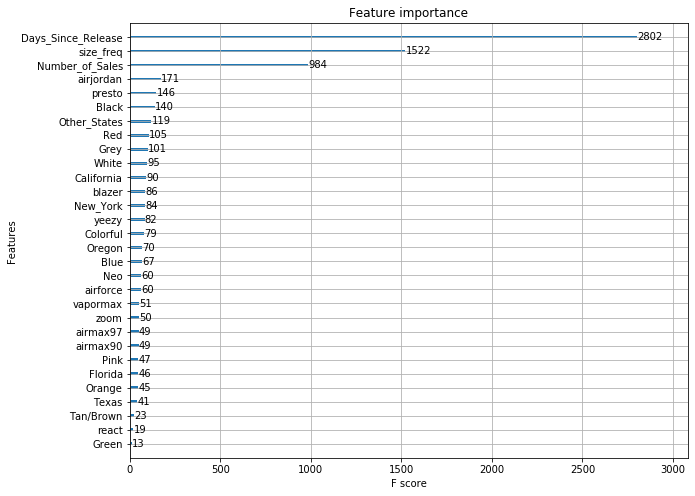

In [42]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [10,8]
plt.show()

In [43]:
error = pd.DataFrame(y_test)
error["predict_y"] = y_pred
error["error"] = error["Pct_change"] - error["predict_y"]
error["error^2"] = error["error"]**2
error['ptg_error']=error["error"]/error["Pct_change"]
error.sort_values(by=['ptg_error'],ascending= False)[:50]

,Pct_change,predict_y,error,error^2,ptg_error
88708,0.000000,-0.007400,0.007400,0.000055,inf
83630,-0.004545,0.103798,-0.108343,0.011738,23.835506
57027,-0.004545,0.103128,-0.107674,0.011594,23.688188
95973,-0.004545,0.101343,-0.105888,0.011212,23.295450
66210,-0.004545,0.087756,-0.092301,0.008520,20.306259
83140,-0.009091,0.134003,-0.143094,0.020476,15.740369
89077,-0.004545,0.058060,-0.062605,0.003919,13.773136
66189,-0.004545,0.042054,-0.046600,0.002172,10.251892
96013,-0.009091,0.072881,-0.081972,0.006719,9.016931
77908,-0.013636,0.108035,-0.121671,0.014804,8.922536


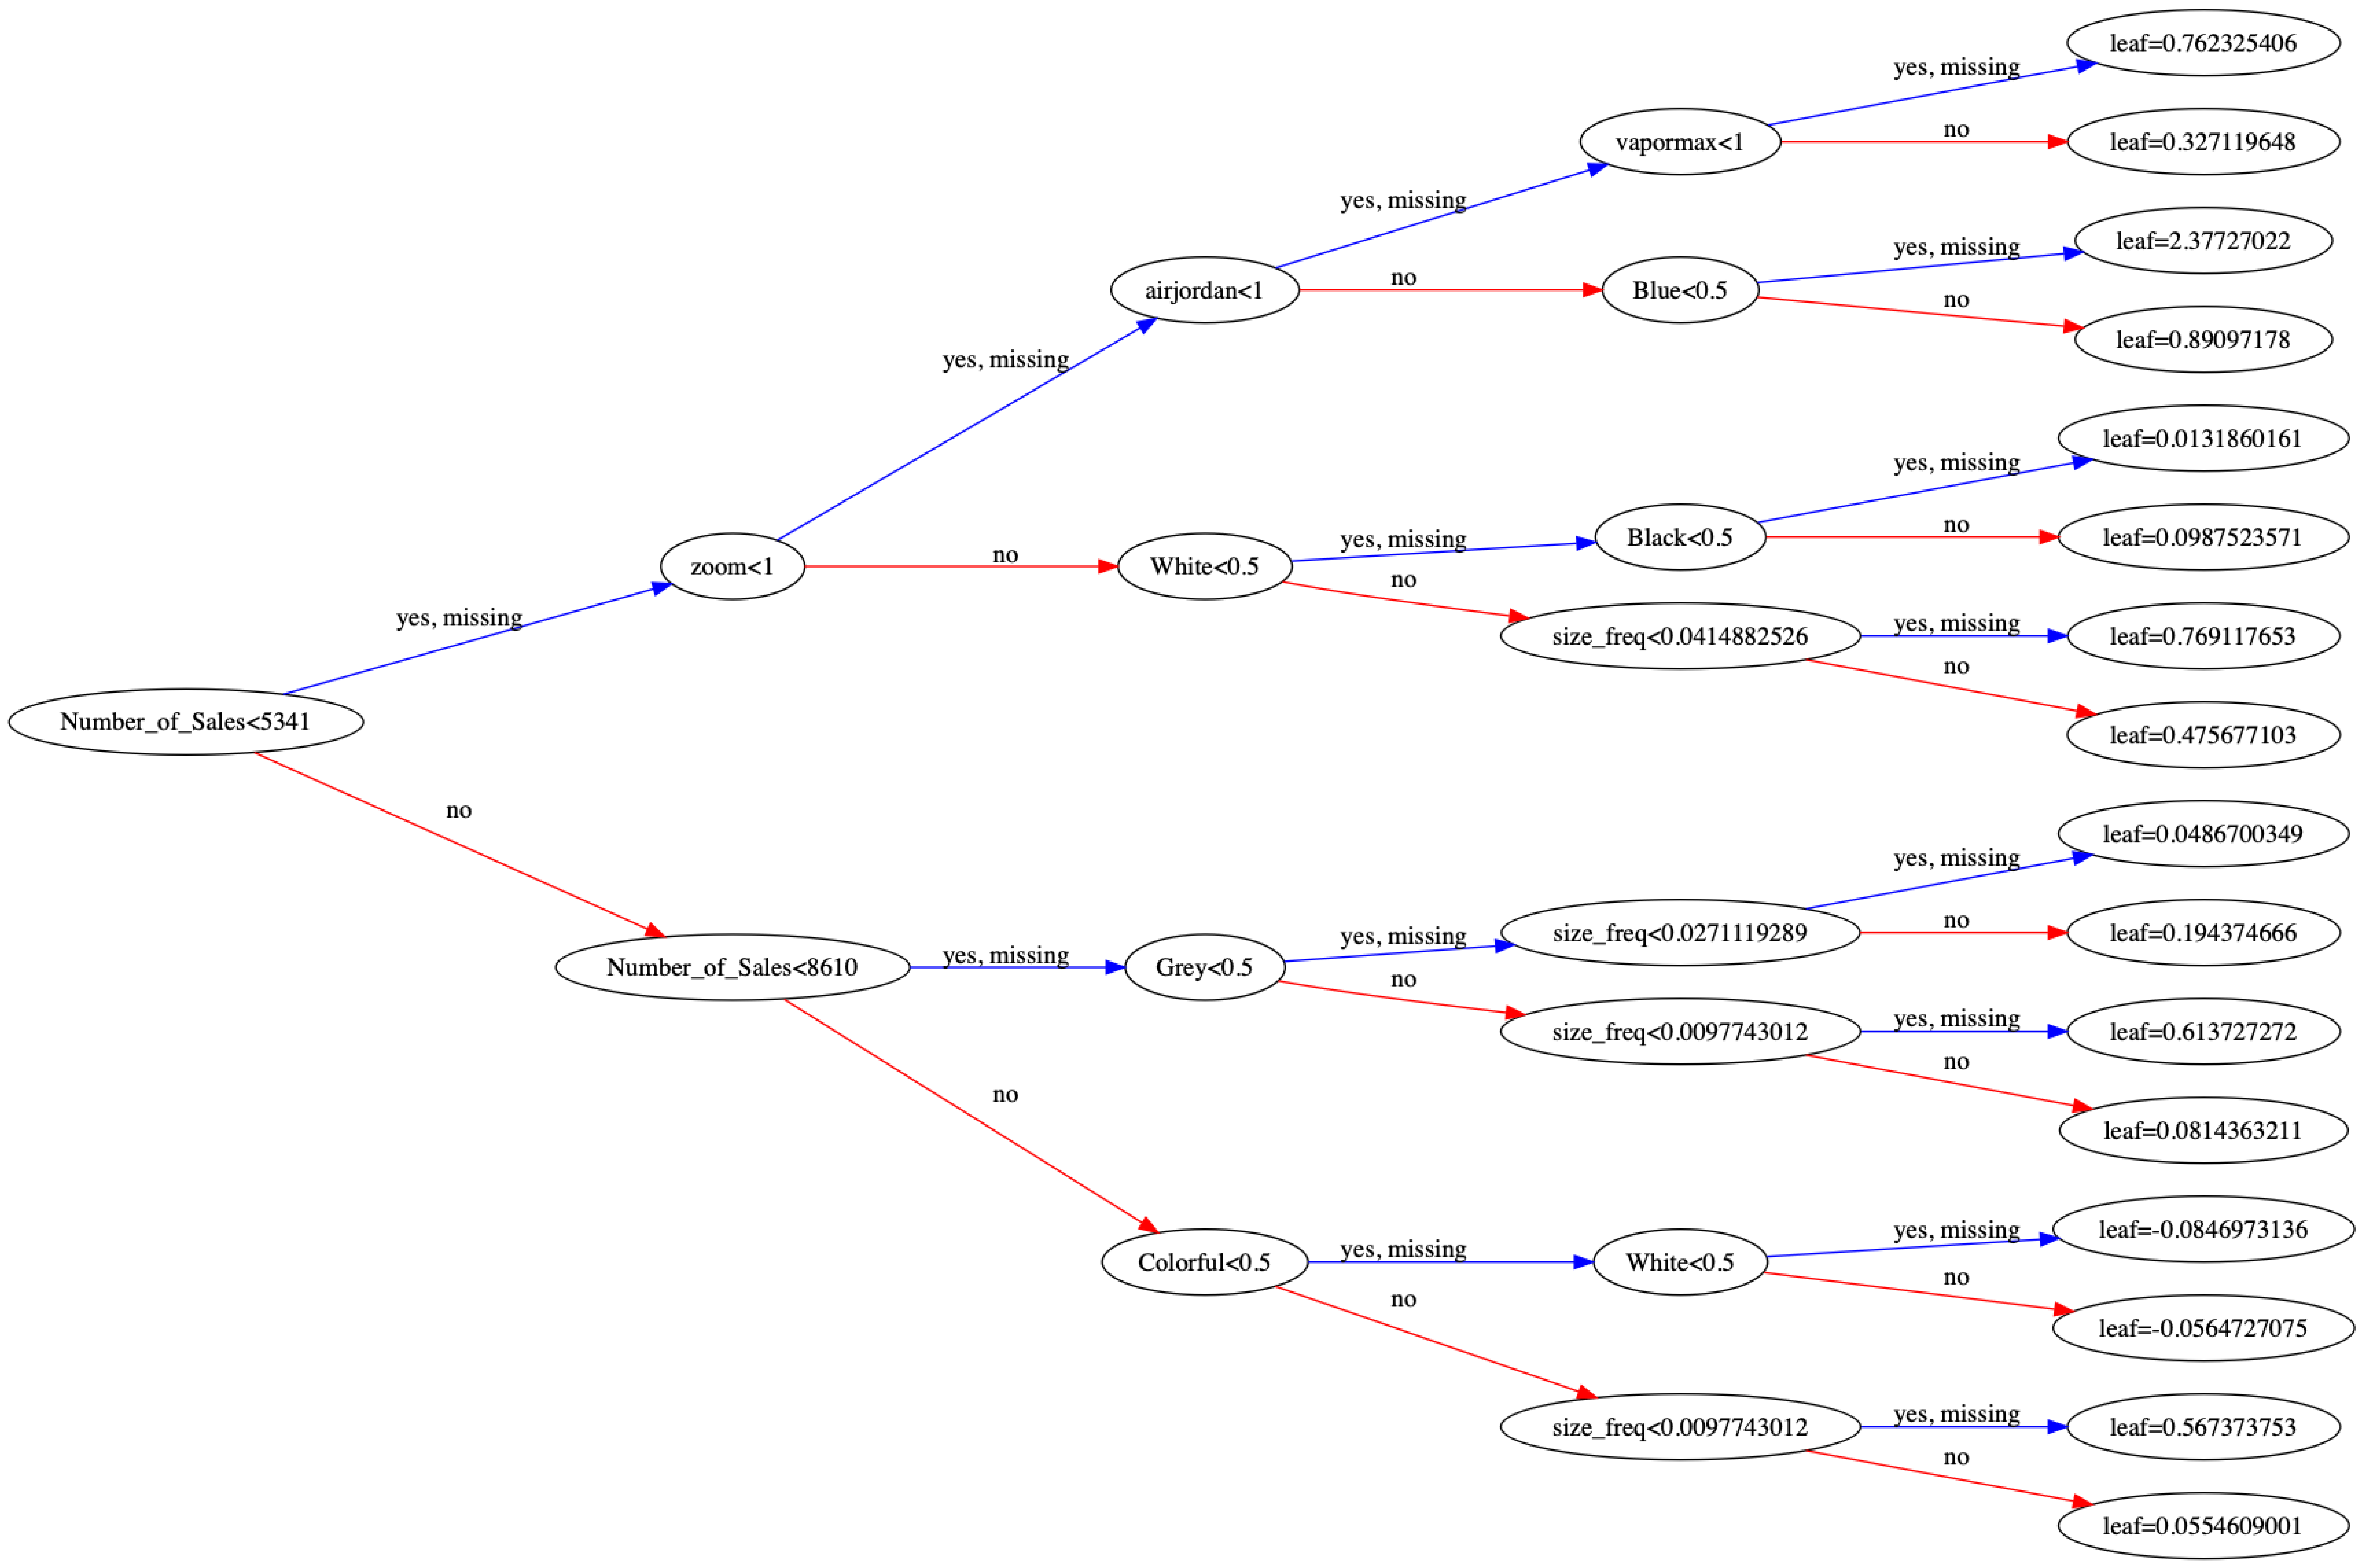

In [44]:
xgb.plot_tree(best_model, num_trees=0, rankdir='LR')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('../data/media/xgboost_tree.png')